This notebook aims to de-trend renewable energy data by identifying seasonal components and over-time growth

## Import the libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
import pyarrow # needed for importing dataframes

# decomposition libs
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")

## Import the data

In [24]:
years = ['22','23','24'] # all years of actual productions we want
zones = ['IT_NORD'] # focus on only one zone
df_actuals = pd.DataFrame()

# extract all years
for year in years:
    filename = f"lcpb_files/20{year}_actuals"
    df_temp = pd.read_parquet(filename)
    #print(f'rows for year 20{year}: {np.shape(df_temp)[0]}')
    df_actuals = pd.concat([df_actuals, df_temp])

# rename zone to node_id
df_actuals['node_id'] = df_actuals['zone']
df_actuals = df_actuals.drop(columns = ['zone'])

# pick only zones of interest (IT_NORD)
df_actuals = df_actuals[df_actuals['node_id'].isin(zones)]
print('rows in sel_actuals:',np.shape(df_actuals)[0])
df_actuals[:5]


rows in sel_actuals: 26376


,solar,wind,hydro,generation,load,node_id
date_time,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,IT_NORD
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,IT_NORD
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,IT_NORD
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,IT_NORD
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,IT_NORD


Here we define a growing time parameter normalized from 0 to 1

In [25]:
# sorting for date_time
df_actuals = df_actuals.sort_values(by = 'date_time')
time = []
for i in range(np.shape(df_actuals)[0]):
    time.append(i)
df_actuals['time'] = np.array(time) / max(time)
df_actuals

,solar,wind,hydro,generation,load,node_id,time
date_time,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,IT_NORD,0.000000
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,IT_NORD,0.000038
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,IT_NORD,0.000076
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,IT_NORD,0.000114
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,IT_NORD,0.000152
...,...,...,...,...,...,...,...
2024-12-31 22:45:00+00:00,0.0,56.0,1216.0,10158.0,11958.0,IT_NORD,0.999848
2024-12-31 23:00:00+00:00,0.0,8.0,218.0,2110.0,11528.0,IT_NORD,0.999886
2024-12-31 23:15:00+00:00,0.0,8.0,214.0,2095.0,11695.0,IT_NORD,0.999924


Let's try to visualize a feature to see if an actual trend is visible or not

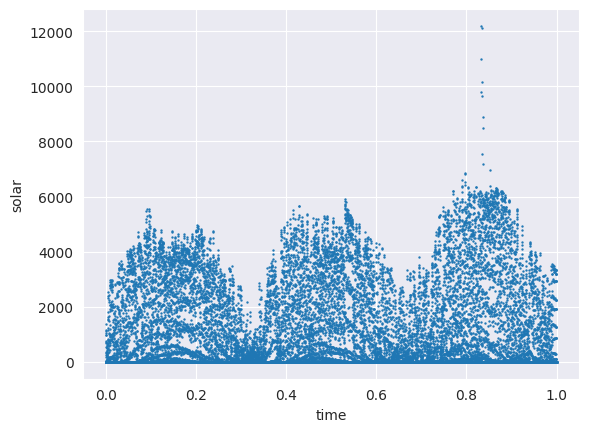

In [26]:
feature = 'solar'
plt.scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
plt.xlabel('time')
plt.ylabel(feature)
plt.show()

A general growing trend is visible, as well as seasonal trends. We need to de-trend the production training data to "rescale" the data for them to be comparable bewtween different years, regardless of the number of solar/wind power planta installed in the territory. 
To apply the Multiple Seasonal-Trend decomposition it is easier to use hourly timescale (to define periodicities). 


## De-trending of solar producution data: Multiple Seasonal-Trend decomposition

In [62]:
# checking for NaNs
missing = df_actuals[feature].isna().sum()
print(f"Number of missing values: {missing}")

# checking for missing timestamps
expected_range = pd.date_range(start=df_actuals.index.min(), end=df_actuals.index.max(), freq="h")
missing_timestamps = expected_range.difference(df_actuals.index)
print(f"Number of missing timestamps: {len(missing_timestamps)}")

Number of missing values: 0
Number of missing timestamps: 0


In [63]:
# the time series has hourly frequency, so the decomposition can be performed:
from time import time

mstl = MSTL(df_actuals[feature], 
            periods=[24, # daily frequency
                     24*30, # monthly frequency
                     #24 * 7*, # weekly frequency
                     24 * 365 # yearly frequency
            ]
               ) # seasonal decomposition algorithm
start_time = time()


# res is an instance of a DecomposeResult-like object, not a plain DataFrame but similar... with trend (smoothed long-term trend) , resid (noise or unexplained part), seasonal_period (seasonal components for each period)

res = mstl.fit()  
finish_time = time()
print('total fit time:', round(finish_time - start_time,3), 's')

total fit time: 561.08 s


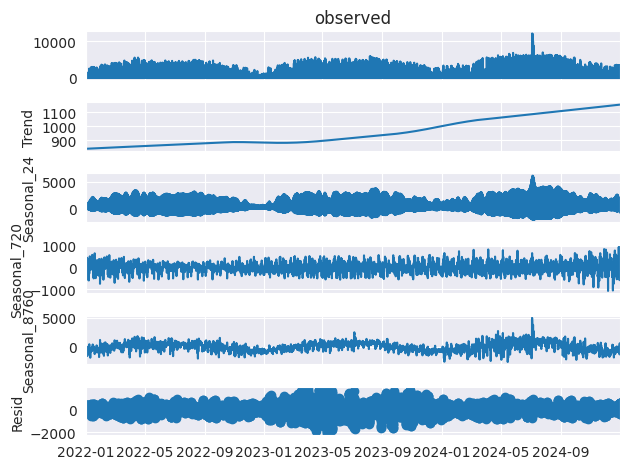

In [64]:
# plot the results
ax = res.plot()
#plt.tight_layout()

In [46]:
# here we also try with a weekly periodicity (difference between workdays and weekends for ex) and compare results

mstl2 = MSTL(df_actuals[feature], 
            periods=[24, # daily frequency
                     #24*30, #month frequency
                     24 * 7, # weekly frequency
                     24 * 365 # yearly frequency
            ]
               ) # seasonal decomposition algorithm


res2 = mstl2.fit()


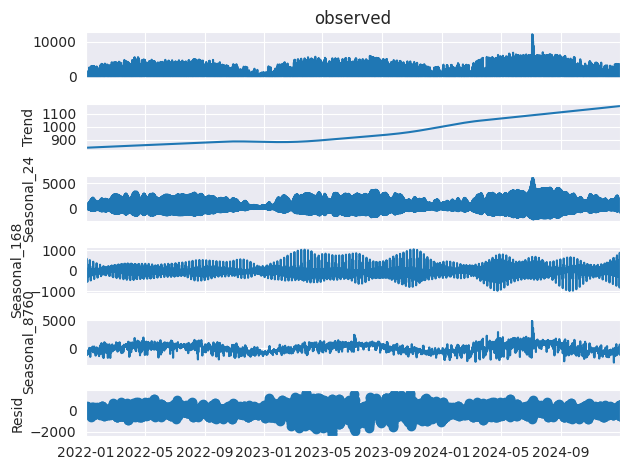

In [49]:
# plot the results
ax = res2.plot()
plt.tight_layout()

No, the first option appears to make more sense, no clear weekly seasonality.

Let's examine the seasonal components in detail

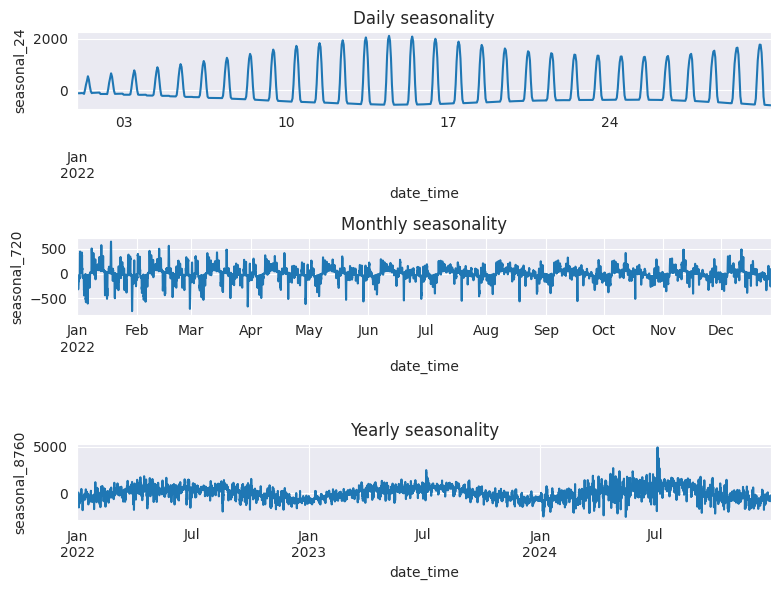

In [56]:
# daily seasonality
fig, ax = plt.subplots(nrows=3, figsize=[8,6])
res.seasonal["seasonal_24"].iloc[:24*30].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

# weekly seasonality
'''
res.seasonal["seasonal_168"].iloc[:24*7*4].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")'''

# monthly seasonality

res.seasonal["seasonal_720"].iloc[:24*30*12].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_720")
ax[1].set_title("Monthly seasonality")

# yearly seasonality
res.seasonal["seasonal_8760"].iloc[:24*365*3].plot(ax=ax[2])
ax[2].set_ylabel("seasonal_8760")
ax[2].set_title("Yearly seasonality")

plt.tight_layout()

In [57]:
# SUBTRACTING UNDERLYING TREND TO GET DE-TRENDED SOLAR DATA TO USE

df_actuals_detrended = df_actuals.copy()
df_actuals_detrended['solar']= df_actuals_detrended['solar']- res.trend
df_actuals_detrended

,solar,wind,hydro,generation,load,node_id,time
date_time,,,,,,,
2022-01-01 00:00:00+00:00,-840.375197,2.0,1110.0,6894.0,10583.0,IT_NORD,0.000000
2022-01-01 01:00:00+00:00,-840.382358,22.0,1063.0,6297.0,10054.0,IT_NORD,0.000038
2022-01-01 02:00:00+00:00,-840.389518,22.0,1057.0,5373.0,9573.0,IT_NORD,0.000076
2022-01-01 03:00:00+00:00,-840.396677,22.0,1089.0,4963.0,9402.0,IT_NORD,0.000114
2022-01-01 04:00:00+00:00,-840.403836,22.0,1053.0,5405.0,9689.0,IT_NORD,0.000152
...,...,...,...,...,...,...,...
2024-12-31 22:45:00+00:00,-1153.352182,56.0,1216.0,10158.0,11958.0,IT_NORD,0.999848
2024-12-31 23:00:00+00:00,-1153.366803,8.0,218.0,2110.0,11528.0,IT_NORD,0.999886
2024-12-31 23:15:00+00:00,-1153.381424,8.0,214.0,2095.0,11695.0,IT_NORD,0.999924


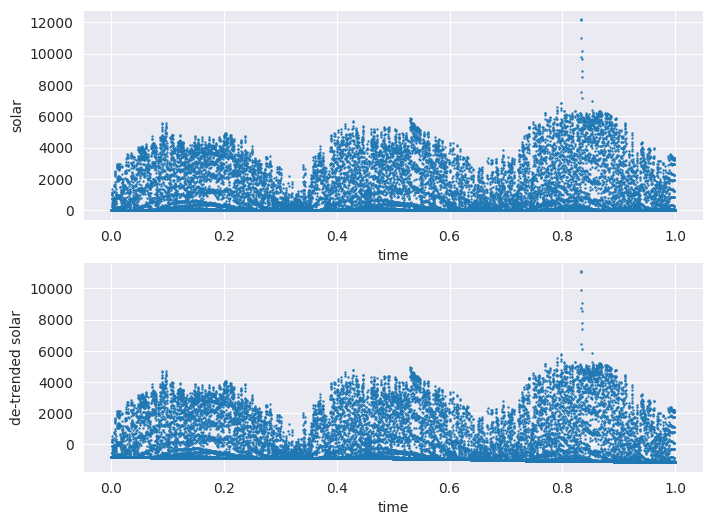

In [58]:
fig, ax = plt.subplots(nrows=2, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')


ax[1].scatter(df_actuals_detrended['time'], df_actuals_detrended['solar'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('de-trended solar')

plt.show()



PROBLEM: Detrending in this way gives negative values. For example whene there is no production at night, despite more plants being installed over the years, the solar production should remain zero, not become negative. This is due to the trend component starting from 900 and not 0. Thus we subtract from the trend component its initial minimum value (offset), and then substitute with 0 all negative values in the de-trended production data.

In [59]:
df_actuals_detrended['solar']= df_actuals_detrended['solar'] + np.min(res.trend)
df_actuals_detrended.loc[df_actuals_detrended['solar'] < 0, 'solar'] = 0

In [60]:
df_actuals_detrended

,solar,wind,hydro,generation,load,node_id,time
date_time,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,IT_NORD,0.000000
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,IT_NORD,0.000038
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,IT_NORD,0.000076
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,IT_NORD,0.000114
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,IT_NORD,0.000152
...,...,...,...,...,...,...,...
2024-12-31 22:45:00+00:00,0.0,56.0,1216.0,10158.0,11958.0,IT_NORD,0.999848
2024-12-31 23:00:00+00:00,0.0,8.0,218.0,2110.0,11528.0,IT_NORD,0.999886
2024-12-31 23:15:00+00:00,0.0,8.0,214.0,2095.0,11695.0,IT_NORD,0.999924


Let's implement a running average to better compare the difference between original and de-trended data.

In [43]:
def cumulative_average(df, column): 
    avg = np.zeros(len(df[column]))
    for i in range(len(df[column])):
        avg[i] = np.mean(df[column].iloc[:i])
    return(avg)

detrended_avg = cumulative_average(df_actuals_detrended,'solar')
original_avg =  cumulative_average(df_actuals,'solar')

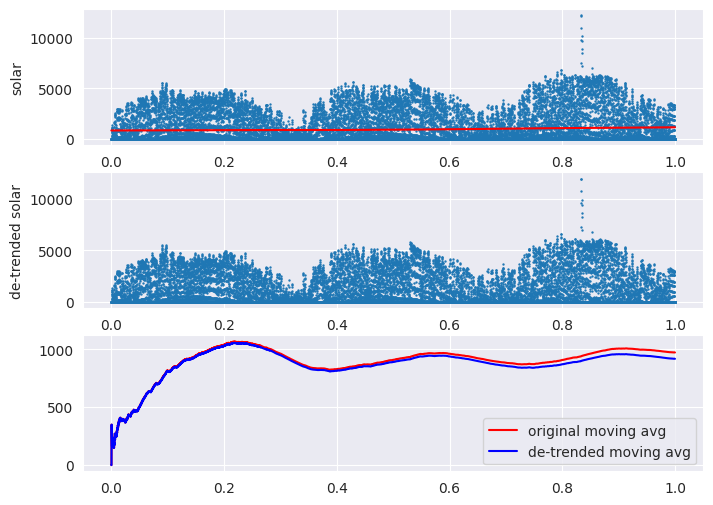

In [62]:


fig, ax = plt.subplots(nrows=3, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
ax[0].plot(df_actuals['time'],res.trend.values,color='red')
ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')


ax[1].scatter(df_actuals_detrended['time'], df_actuals_detrended['solar'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('de-trended solar')

ax[2].plot(df_actuals['time'],original_avg, color='red',label='original moving avg')
ax[2].plot(df_actuals_detrended['time'],detrended_avg, color='blue',label='de-trended moving avg')
ax[2].legend()
plt.show()

# De-trending using a Linear Fit instead of MSTL

In [55]:
slope, intercept = np.polyfit(np.array(df_actuals['time']), np.array(df_actuals['solar']), 1)

Similarly here, we want the linear fit not to be offset (to start from 0 to model only the increase due to more power plant installations), thus we subtract from itself its mininum value (intercept). Then we set to zero all the negative values in the detrended data.

In [56]:
lin_trend = np.array(df_actuals['time'])*slope
lin_trend = pd.DataFrame( np.vstack([lin_trend,df_actuals['time'].values]).T, index = df_actuals.index, columns= ['linear fit','time'])
lin_trend

,linear fit,time
date_time,,
2022-01-01 00:00:00+00:00,0.000000,0.000000
2022-01-01 01:00:00+00:00,0.008818,0.000038
2022-01-01 02:00:00+00:00,0.017635,0.000076
2022-01-01 03:00:00+00:00,0.026453,0.000114
2022-01-01 04:00:00+00:00,0.035270,0.000152
...,...,...
2024-12-31 22:45:00+00:00,232.527454,0.999848
2024-12-31 23:00:00+00:00,232.536271,0.999886
2024-12-31 23:15:00+00:00,232.545089,0.999924


In [57]:

df_lin_detrend = df_actuals['solar']-lin_trend['linear fit']
df_lin_detrend= pd.DataFrame(np.vstack([df_lin_detrend,df_actuals['time'].values]).T, index=lin_trend.index,columns=['solar detrended','time'])
df_lin_detrend.loc[df_lin_detrend['solar detrended'] < 0, 'solar detrended'] = 0
detrended_avg = cumulative_average(df_lin_detrend,'solar detrended')


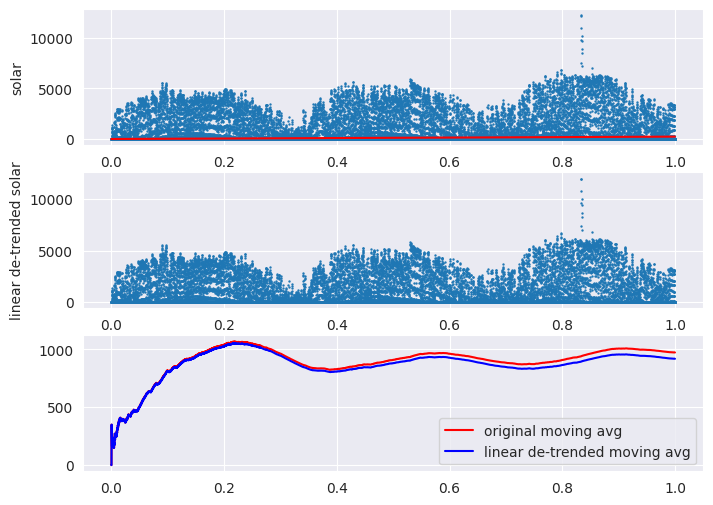

In [58]:
fig, ax = plt.subplots(nrows=3, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
ax[0].plot(df_actuals['time'],lin_trend['linear fit'],color='red')
ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')
#ax[0].set_ylim(0,1200)

ax[1].scatter(df_lin_detrend['time'], df_lin_detrend['solar detrended'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('linear de-trended solar')

ax[2].plot(df_actuals['time'],original_avg, color='red',label='original moving avg')
ax[2].plot(df_lin_detrend['time'],detrended_avg, color='blue',label='linear de-trended moving avg')
ax[2].legend()
plt.show()

# De-trending using national installation power data

Another possibility, for the Italian zones forecasting, is using the available total power installation data (in MW) for each year. Only overall national data are available, not divided between market zones, thus we are forced to apprixamate the trend of increasing power installed to be equally distributed among the zones.     

In [35]:
power_installed = pd.read_csv('lcpb_files/potenze_mw_installato_annuale_italia.csv',delimiter=';')
power_installed = power_installed.iloc[:,0:4]
power_installed

,Anno,Idrica,Eolica,Solare
0,2020,19106,10907,21650
1,2021,19172,11290,22594
2,2022,19265,11858,25064
3,2023,19274,12336,30319
4,2024,21569,13021,37076


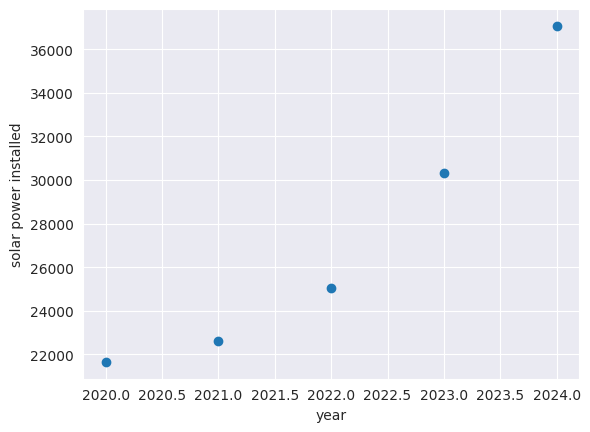

In [36]:
plt.scatter(power_installed['Anno'],power_installed['Solare'])
plt.xlabel('year')
plt.ylabel('solar power installed')
plt.show()

We perform a parabolic fit, normalising both times and power installed in the interval [0:1].  

In [37]:
power_installed['time'] = np.array((power_installed['Anno']-2020)/4) 
power_installed['Solare'] = np.array((power_installed['Solare']-min(power_installed['Solare']))/ (max(power_installed['Solare'])-min(power_installed['Solare'])))  
power_installed

,Anno,Idrica,Eolica,Solare,time
0,2020,19106,10907,0.000000,0.00
1,2021,19172,11290,0.061195,0.25
2,2022,19265,11858,0.221315,0.50
3,2023,19274,12336,0.561973,0.75
4,2024,21569,13021,1.000000,1.00


In [38]:
a_pw, b_pw, c_pw = np.polyfit(np.array(power_installed['time']), np.array(power_installed['Solare']), 2)
parabolic_trend= df_actuals['time']*b_pw + df_actuals['time']**2 *a_pw  # starts at 0 at t=0 (trend of increase) 

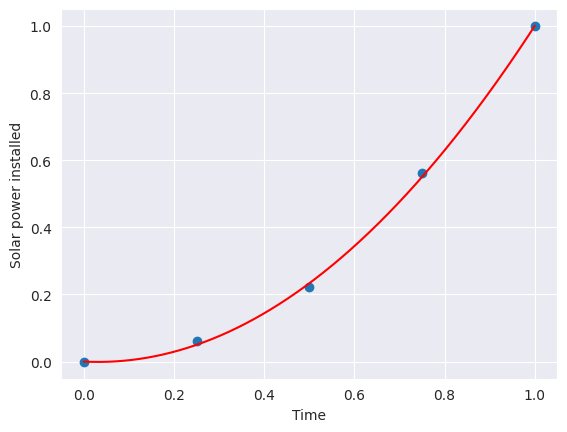

In [39]:
plt.scatter(power_installed['time'],power_installed['Solare'])
plt.xlabel('Time')
plt.ylabel('Solar power installed')
plt.plot(df_actuals['time'], parabolic_trend,color='red')
plt.show()

We de-trend the production data by subtracting the difference between the average production in the last year and in the first year, rescaled by the parabolic fit of the installed power.  

In [40]:
first_year_solar_prod_avg = np.mean(df_actuals.loc[df_actuals['time']<1/3,'solar'].values) #prod avg during 2021
last_year_solar_prod_avg=  np.mean(df_actuals.loc[df_actuals['time']>2/3,'solar'].values) #prod avg during 2023
print(first_year_solar_prod_avg,last_year_solar_prod_avg)

881.4739535941766 1102.4628070973613


In [41]:
df_power_detrended = df_actuals.copy()
df_power_detrended['solar detrended'] =  df_actuals['solar'] - (last_year_solar_prod_avg-first_year_solar_prod_avg)*parabolic_trend 
df_power_detrended

,solar,wind,hydro,generation,load,node_id,time,solar detrended
date_time,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,IT_NORD,0.000000,0.000000
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,IT_NORD,0.000038,0.000564
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,IT_NORD,0.000076,0.001127
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,IT_NORD,0.000114,0.001690
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,IT_NORD,0.000152,0.002252
...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00+00:00,0.0,56.0,1216.0,10158.0,11958.0,IT_NORD,0.999848,-220.988315
2024-12-31 23:00:00+00:00,0.0,8.0,218.0,2110.0,11528.0,IT_NORD,0.999886,-221.005639
2024-12-31 23:15:00+00:00,0.0,8.0,214.0,2095.0,11695.0,IT_NORD,0.999924,-221.022964


In [51]:
df_power_detrended.loc[df_power_detrended['solar detrended']<0,'solar detrended']=0 # fix negative values to 0
df_power_detrended

,solar,wind,hydro,generation,load,node_id,time,solar detrended
date_time,,,,,,,,
2022-01-01 00:00:00+00:00,0.0,2.0,1110.0,6894.0,10583.0,IT_NORD,0.000000,0.000000
2022-01-01 01:00:00+00:00,0.0,22.0,1063.0,6297.0,10054.0,IT_NORD,0.000038,0.000564
2022-01-01 02:00:00+00:00,0.0,22.0,1057.0,5373.0,9573.0,IT_NORD,0.000076,0.001127
2022-01-01 03:00:00+00:00,0.0,22.0,1089.0,4963.0,9402.0,IT_NORD,0.000114,0.001690
2022-01-01 04:00:00+00:00,0.0,22.0,1053.0,5405.0,9689.0,IT_NORD,0.000152,0.002252
...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00+00:00,0.0,56.0,1216.0,10158.0,11958.0,IT_NORD,0.999848,0.000000
2024-12-31 23:00:00+00:00,0.0,8.0,218.0,2110.0,11528.0,IT_NORD,0.999886,0.000000
2024-12-31 23:15:00+00:00,0.0,8.0,214.0,2095.0,11695.0,IT_NORD,0.999924,0.000000


In [52]:
cumulative_avg = cumulative_average(df_power_detrended,'solar detrended')

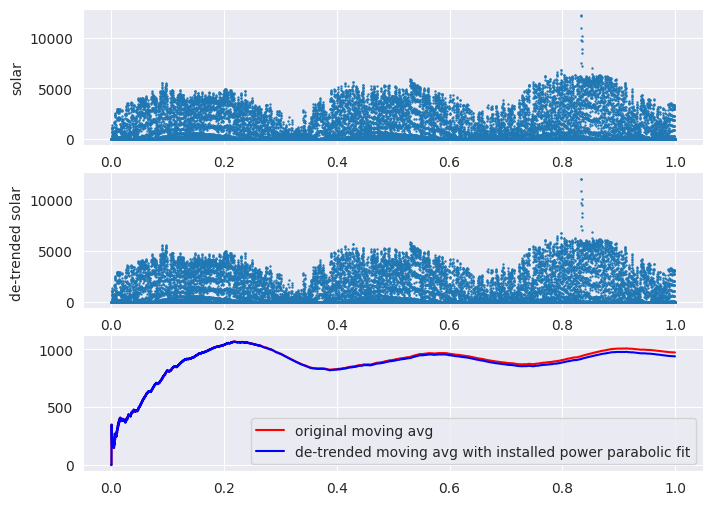

In [53]:
fig, ax = plt.subplots(nrows=3, figsize=[8,6])

ax[0].scatter(df_actuals['time'], df_actuals['solar'], s = 0.5)
#ax[0].plot(df_actuals['time'],lin_trend['linear fit'],color='red')
ax[0].set_xlabel('time')
ax[0].set_ylabel('solar')


ax[1].scatter(df_power_detrended['time'], df_power_detrended['solar detrended'], s = 0.5)
ax[1].set_xlabel('time')
ax[1].set_ylabel('de-trended solar ')

ax[2].plot(df_actuals['time'],original_avg, color='red',label='original moving avg')
ax[2].plot(df_power_detrended['time'],cumulative_avg, color='blue',label='de-trended moving avg with installed power parabolic fit')
ax[2].legend()

plt.show()

## Trend correction comparison 

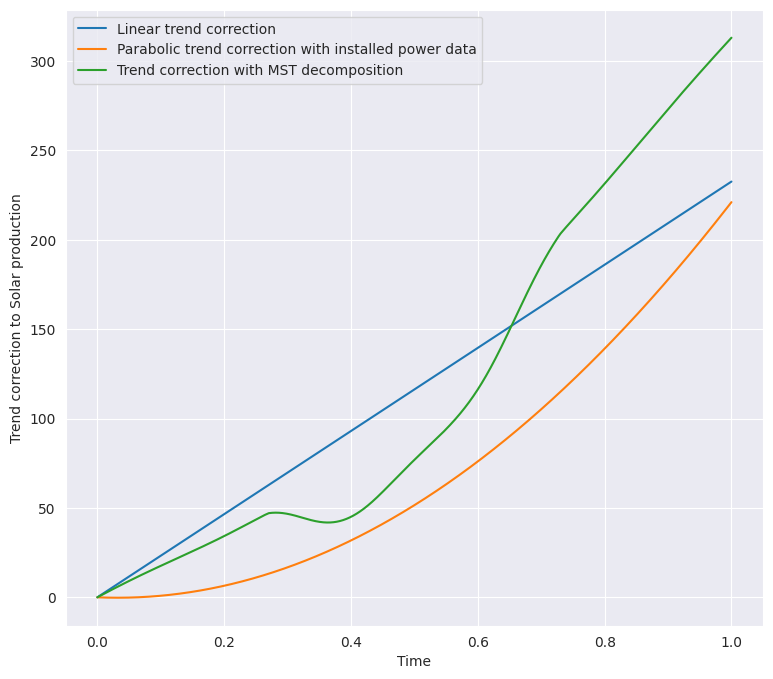

In [70]:
fig,ax= plt.subplots(1,figsize=[9,8])
ax.plot(lin_trend['time'],lin_trend['linear fit'],label='Linear trend correction')
ax.plot(df_power_detrended['time'],(last_year_solar_prod_avg-first_year_solar_prod_avg)*parabolic_trend,label='Parabolic trend correction with installed power data')
ax.plot(df_actuals['time'],res.trend-np.min(res.trend),label='Trend correction with MST decomposition')
ax.set_xlabel('Time')
ax.set_ylabel('Trend correction to Solar production')
plt.legend()
